# Identifying the stages of the business cycle in the USA

by Giancarlo Marchesi

The goal of this project is to identify the four stages of an economic cycle in the United States:

The stages are as follows: 
- **Recovery**: period immediately after a slowdon or recession
- **Expansion**: stable growth period after a recovery period
- **Slowdown**: period of stagnant or decreasing growth that may precede a recessions or might happen in the middle of a cycle
- **Contraction**: period of decreasing growth, following a slowdown

To determine these stages, I'll use The Conference Board's Leading Economic Index (LEI), the longest running and most reputable leading indicator in the market. I constrast the findings of this methodology with the Coincident Economic Index (CEI), also from the Conference Board, and the official National Bureau of Economic Research (NBER) classification of the business cycle (month of expansion or contraction).

In [1]:
##!pip install xlsxwriter
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statistics
import xlsxwriter
import random
import datetime
import time
import matplotlib.ticker as mtick

## Reading the data & EDA

In [2]:
## Importing the data 
df=pd.read_csv('Economic.csv', sep=';')

In [3]:
df.head(3)

,month,LEI,CEI,GDP,NBER,Fed_Funds,Inflation
0,7/01/1972,50.3,39.5,3.8,expansion,4.55,2.9
1,8/01/1972,51.0,39.9,3.8,expansion,4.81,2.9
2,9/01/1972,51.6,40.2,3.8,expansion,4.87,3.2


In [4]:
df.tail(3)

,month,LEI,CEI,GDP,NBER,Fed_Funds,Inflation
600,7/01/2022,116.5,108.6,2.9,expansion,1.58,8.5
601,8/01/2022,116.2,108.7,2.9,expansion,2.33,8.3
602,9/01/2022,115.8,108.9,2.9,expansion,3.08,8.2


In [5]:
rows=df.shape[0] #number of rows
columns=df.shape[1]  #number of columns

In [6]:
df.shape

(603, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   month      603 non-null    object 
 1   LEI        603 non-null    float64
 2   CEI        603 non-null    float64
 3   GDP        603 non-null    float64
 4   NBER       603 non-null    object 
 5   Fed_Funds  603 non-null    float64
 6   Inflation  603 non-null    float64
dtypes: float64(5), object(2)
memory usage: 33.1+ KB


The dataset has information about the LEI, CEI, the gross domestic product, the NBER clasification of the business cycle the effective fed funds rate and inflation dating back to 1972. The working hypothesis is that the patterns of deceleration and acceleration of the economy, and hence its four stages, can be tracked through LEI monthly, quarterly and semi-annual changes. 

In this workbook we estimate the changes in LEI and create a new file with the columns needed for visualizations and further analysis. 

In [8]:
## Creating a variable for the name of output file so succesive versions can be created after modificactions by file_name
output_file_name="LEI_deltas"
output_file_description="-" #optional file description 

In [9]:
## The dates loaded the first day of the month (this is not actually true as LEI comes out the 3rd Thursday). 
## Let's just keep the month marking
## Changing month to datetime format, because now it's an object
df['month']=df['month'].astype('datetime64')

In [10]:
## Changing the format to just month/year
df['month'] = df['month'].dt.strftime('%m/%Y') 

##strftime turns it back into a string type, but since the observations are already ordered it won't matter much when producing visualizations 

In [11]:
## Checking that the format changed 
df.head()

,month,LEI,CEI,GDP,NBER,Fed_Funds,Inflation
0,07/1972,50.3,39.5,3.8,expansion,4.55,2.9
1,08/1972,51.0,39.9,3.8,expansion,4.81,2.9
2,09/1972,51.6,40.2,3.8,expansion,4.87,3.2
3,10/1972,52.0,40.7,6.9,expansion,5.05,3.4
4,11/1972,52.5,41.0,6.9,expansion,5.06,3.7


## Feature engineering

In [12]:
## These are the change variables we want to include in the dataframe for analysis
delta_1m_LEI=0   ## change in one month
delta_3m_LEI=0   ## change in three months
delta_6m_LEI=0   ## change in six months
sign_delta_1m_LEI=0 ## the sing of the change in delta _1m
sign_delta_3m_LEI=0 ## the sing of the change in delta _3m
sign_delta_6m_LEI=0 ## the sing of the change in delta _6m

## Initializing lists to store the values of estimations to later export to a new CSV file. 
## delta lists start with zero, since no estimations have been performed yet.  
## we are deconstructing the df to produce a new one 
list_month=[df["month"][0]] 
list_LEI=[df["LEI"][0]] 
list_CEI=[df["CEI"][0]] 
list_NBER=[df["NBER"][0]] 
list_delta_1m_LEI=[0]
list_delta_3m_LEI=[0]
list_delta_6m_LEI=[0]
list_sign_delta_1m_LEI=[0]
list_sign_delta_3m_LEI=[0]
list_sign_delta_6m_LEI=[0]


In [13]:
### Estimating the changes in LEI (one, three and six months) and the signs and appending to corresponding lists
### For the sign_delta variables, 1 is assigned to positive changes and 0 to negative changes  
for i in range(1,rows,1):
    delta_1m_LEI=((df["LEI"][i]-df["LEI"][i-1])/df["LEI"][i-1])
    if i>=3:
        delta_3m_LEI=((df["LEI"][i]-df["LEI"][i-3])/df["LEI"][i-3])
    if i>=6:
        delta_6m_LEI=((df["LEI"][i]-df["LEI"][i-6])/df["LEI"][i-6])
    if delta_1m_LEI > 0:
        sign_delta_1m_LEI=1
    else: 
        sign_delta_1m_LEI=0      
    if delta_3m_LEI > 0:
        sign_delta_3m_LEI=1
    else: 
        sign_delta_3m_LEI=0 
    if delta_6m_LEI > 0:
        sign_delta_6m_LEI=1
    else: 
        sign_delta_6m_LEI=0 

    list_delta_1m_LEI.append(delta_1m_LEI)
    list_delta_3m_LEI.append(delta_3m_LEI)
    list_delta_6m_LEI.append(delta_6m_LEI)
 
    list_sign_delta_1m_LEI.append(sign_delta_1m_LEI)
    list_sign_delta_3m_LEI.append(sign_delta_3m_LEI)
    list_sign_delta_6m_LEI.append(sign_delta_6m_LEI)

## extracting the correspoding values for new dataframe that will be created with the delta and sign columns   
    list_month.append(df["month"][i]) 
    list_LEI.append(df["LEI"][i])
    list_CEI.append(df["CEI"][i]) 
    list_NBER.append(df["NBER"][i]) 

In [14]:
data_output={
  
    "month":list_month,
    "LEI": list_LEI,
    "CEI":list_CEI,
    "NBER": list_NBER,
    "delta_1m_LEI":list_delta_1m_LEI,
    "delta_3m_LEI":list_delta_3m_LEI,
    "delta_6m_LEI":list_delta_6m_LEI,
    "sign_delta_1m_LEI": list_sign_delta_1m_LEI,
    "sign_delta_3m_LEI": list_sign_delta_3m_LEI,
    "sign_delta_6m_LEI": list_sign_delta_6m_LEI,
 
    }

In [15]:
df2 = pd.DataFrame(data=data_output)

In [16]:
df2.head()

,month,LEI,CEI,NBER,delta_1m_LEI,delta_3m_LEI,delta_6m_LEI,sign_delta_1m_LEI,sign_delta_3m_LEI,sign_delta_6m_LEI
0,07/1972,50.3,39.5,expansion,0.000000,0.000000,0.0,0,0,0
1,08/1972,51.0,39.9,expansion,0.013917,0.000000,0.0,1,0,0
2,09/1972,51.6,40.2,expansion,0.011765,0.000000,0.0,1,0,0
3,10/1972,52.0,40.7,expansion,0.007752,0.033797,0.0,1,1,0
4,11/1972,52.5,41.0,expansion,0.009615,0.029412,0.0,1,1,0


*The dataframe is ready for analysis*

In [17]:
df2.tail(6)

,month,LEI,CEI,NBER,delta_1m_LEI,delta_3m_LEI,delta_6m_LEI,sign_delta_1m_LEI,sign_delta_3m_LEI,sign_delta_6m_LEI
597,04/2022,118.8,108.6,expansion,-0.004191,0.002532,0.005927,0,1,1
598,05/2022,118.3,108.8,expansion,-0.004209,-0.009213,-0.004209,0,0,0
599,06/2022,117.1,108.1,expansion,-0.010144,-0.018441,-0.018441,0,0,0
600,07/2022,116.5,108.6,expansion,-0.005124,-0.019360,-0.016878,0,0,0
601,08/2022,116.2,108.7,expansion,-0.002575,-0.017751,-0.026801,0,0,0
602,09/2022,115.8,108.9,expansion,-0.003442,-0.011102,-0.029338,0,0,0


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              603 non-null    object 
 1   LEI                603 non-null    float64
 2   CEI                603 non-null    float64
 3   NBER               603 non-null    object 
 4   delta_1m_LEI       603 non-null    float64
 5   delta_3m_LEI       603 non-null    float64
 6   delta_6m_LEI       603 non-null    float64
 7   sign_delta_1m_LEI  603 non-null    int64  
 8   sign_delta_3m_LEI  603 non-null    int64  
 9   sign_delta_6m_LEI  603 non-null    int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 47.2+ KB


## Analyzing one, three and six month deltas of LEI

In [19]:
## This will help visualize how the extremes are associated with NBER classification 
perc = [0.01, 0.025, 0.05, 0.95]
cat_columns = ['delta_1m_LEI', 'delta_3m_LEI', 'delta_6m_LEI']

# Loop through each column...
for column in cat_columns:
    for p in perc:  
        i= df2[column].quantile(p) 
        _th=100*p
        percent=round(i*100, 2)
        print(f'The {_th} th quantile for {column} is {percent} %')
    print('\n')

The 1.0 th quantile for delta_1m_LEI is -2.48 %
The 2.5 th quantile for delta_1m_LEI is -1.76 %
The 5.0 th quantile for delta_1m_LEI is -1.26 %
The 95.0 th quantile for delta_1m_LEI is 1.11 %


The 1.0 th quantile for delta_3m_LEI is -6.37 %
The 2.5 th quantile for delta_3m_LEI is -4.49 %
The 5.0 th quantile for delta_3m_LEI is -3.33 %
The 95.0 th quantile for delta_3m_LEI is 2.74 %


The 1.0 th quantile for delta_6m_LEI is -9.79 %
The 2.5 th quantile for delta_6m_LEI is -7.55 %
The 5.0 th quantile for delta_6m_LEI is -6.26 %
The 95.0 th quantile for delta_6m_LEI is 5.12 %




### Plotting the different LEI deltas against the NBER classification

#### Delta 1m against expansion (green) and recession (red) backgrounds

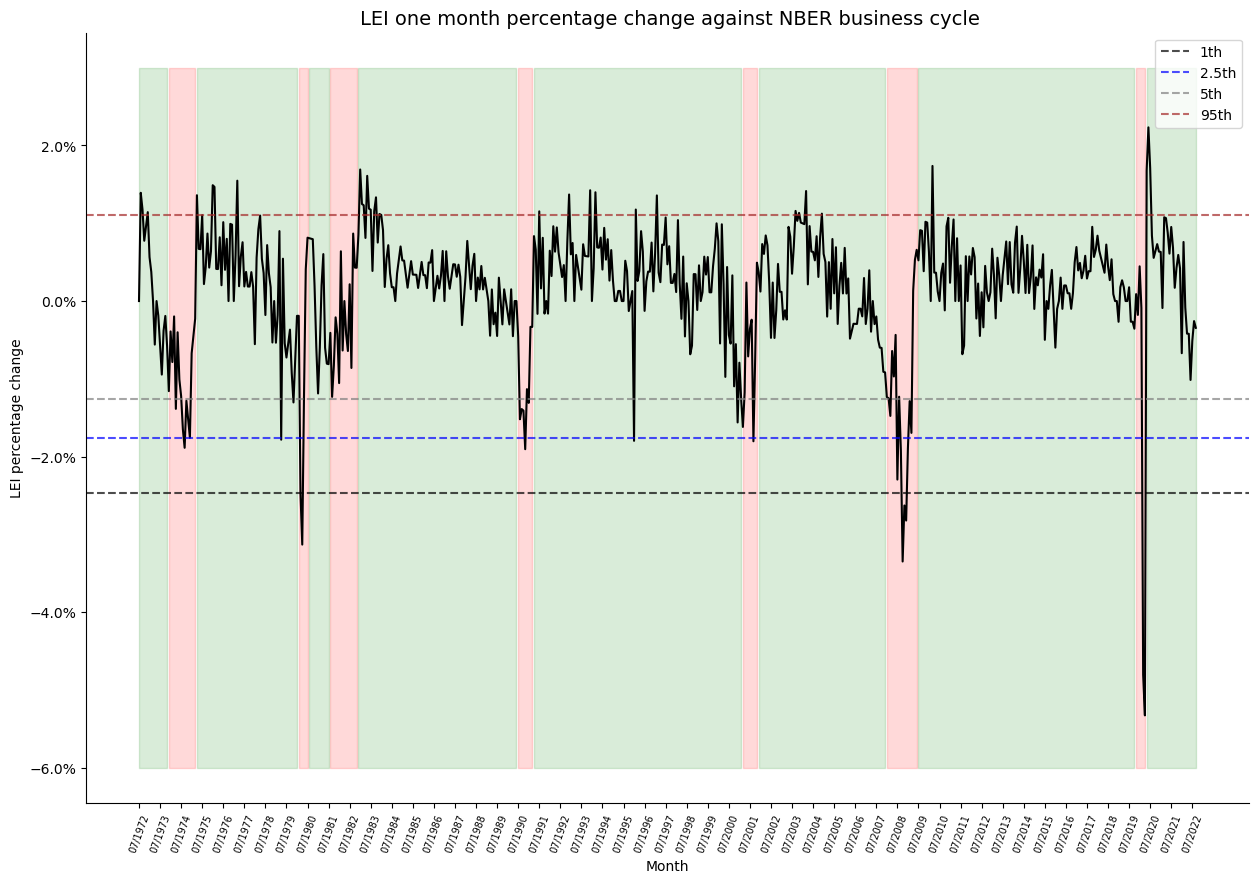

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
x = df2['month']
y = df2['delta_1m_LEI']*100
ax.plot(x, y, color='black')
sub = df2.month[::12]
ax.set_xticks(sub)
ax.set_xticklabels(sub, fontdict={'fontsize':7}, rotation=70)
plt.xlabel('Month')
plt.ylabel('LEI percentage change')
plt.title(' LEI one month percentage change against NBER business cycle', size=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
sns.despine()

threshold_1=-0.0247*100 ## at the 1th percentile
threshold_2=-0.0176*100 ## at the 2.5th percentile
threshold_3=-0.0126*100 ## at the 5th percentile
threshold_4= 0.011*100 ## at the 95th percentile
ax.axhline(threshold_1, color='black' , alpha=0.7, linestyle="--", label='1th')
ax.axhline(threshold_2, color='blue' , alpha=0.7, linestyle="--", label='2.5th')
ax.axhline(threshold_3, color='grey' , alpha=0.7, linestyle="--", label='5th' )
ax.axhline(threshold_4, color='brown' , alpha=0.7, linestyle="--", label='95th');
plt.legend()
 
ax.fill_between(x, -6, 3, where=df['NBER'] =="expansion",
               color='green', alpha=0.15 )
ax.fill_between(x, -6, 3, where=df['NBER']=="contraction",
               color='red', alpha=0.15 )
plt.savefig("One_month_LEI_delta.png")
plt.show();

There seems to be a pattern, with the largest decreases (at the 5th percentile) happening during recessions. However there are false readings in 1978 and 1996. **In 2022, we have not yet reached that level.**

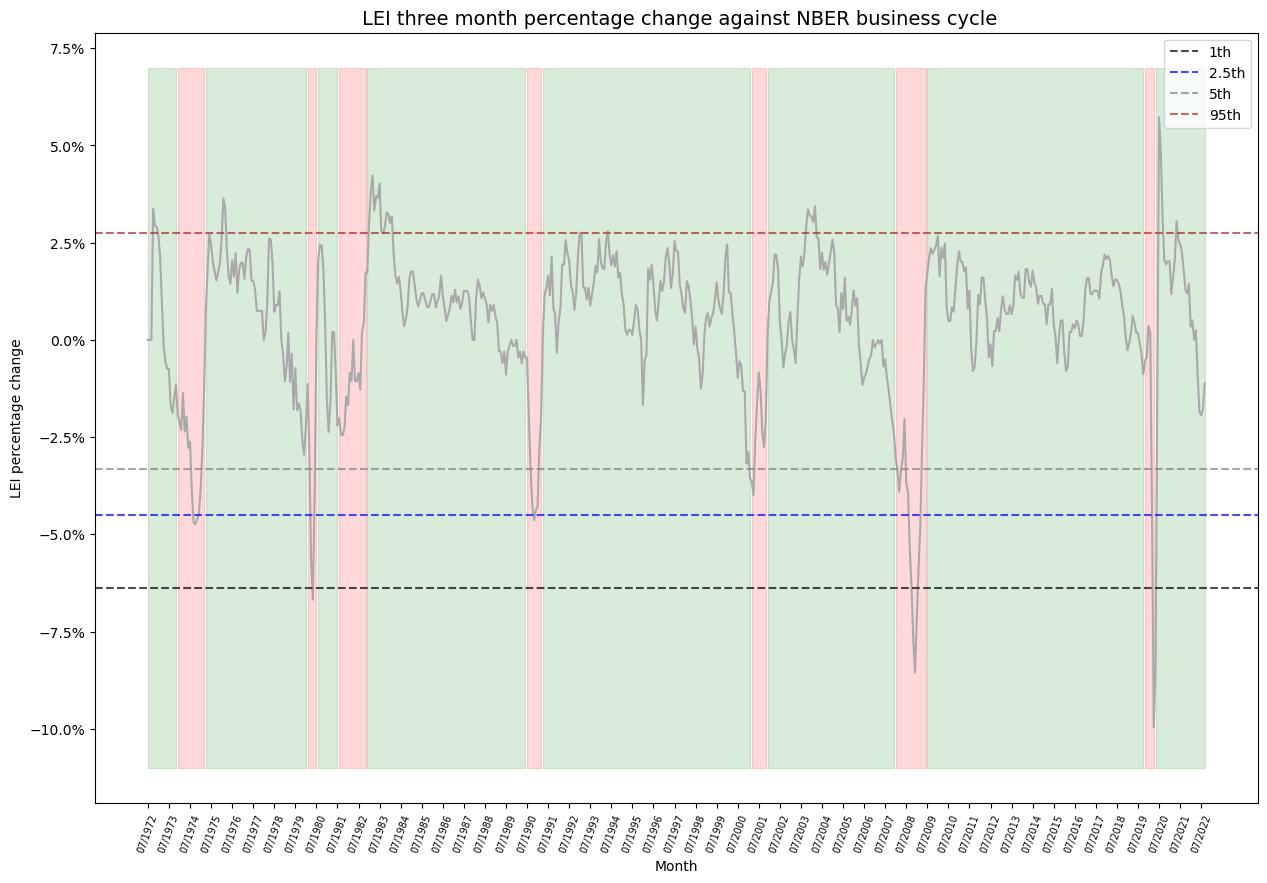

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
x = df2['month']
y = df2['delta_3m_LEI']*100
ax.plot(x, y, color='darkgrey')
sub = df2.month[::12]
ax.set_xticks(sub)
ax.set_xticklabels(sub, fontdict={'fontsize':7}, rotation=70)
plt.xlabel('Month')
plt.ylabel('LEI percentage change')
plt.title(' LEI three month percentage change against NBER business cycle', size=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

threshold_1=-0.0638*100
threshold_2=-0.0449*100
threshold_3=-0.0333*100
threshold_4= 0.0274*100
ax.axhline(threshold_1, color='black' , alpha=0.7, linestyle="--", label='1th')
ax.axhline(threshold_2, color='blue' , alpha=0.7, linestyle="--", label='2.5th')
ax.axhline(threshold_3, color='grey' , alpha=0.7, linestyle="--", label='5th' )
ax.axhline(threshold_4, color='brown' , alpha=0.7, linestyle="--", label='95th')
plt.legend()

 
ax.fill_between(x, -11, 7, where=df['NBER'] =="expansion",
               color='green', alpha=0.15 )
ax.fill_between(x, -11, 7, where=df['NBER'] =="contraction",
               color='red', alpha=0.15 )
plt.savefig("Three_month_LEI_delta.png")
plt.show();

The lowest points of the 3 month deltas, in the 5th percentile can be found during recessions. All deltas in recessions reach the 5th percentile, except 2001.  

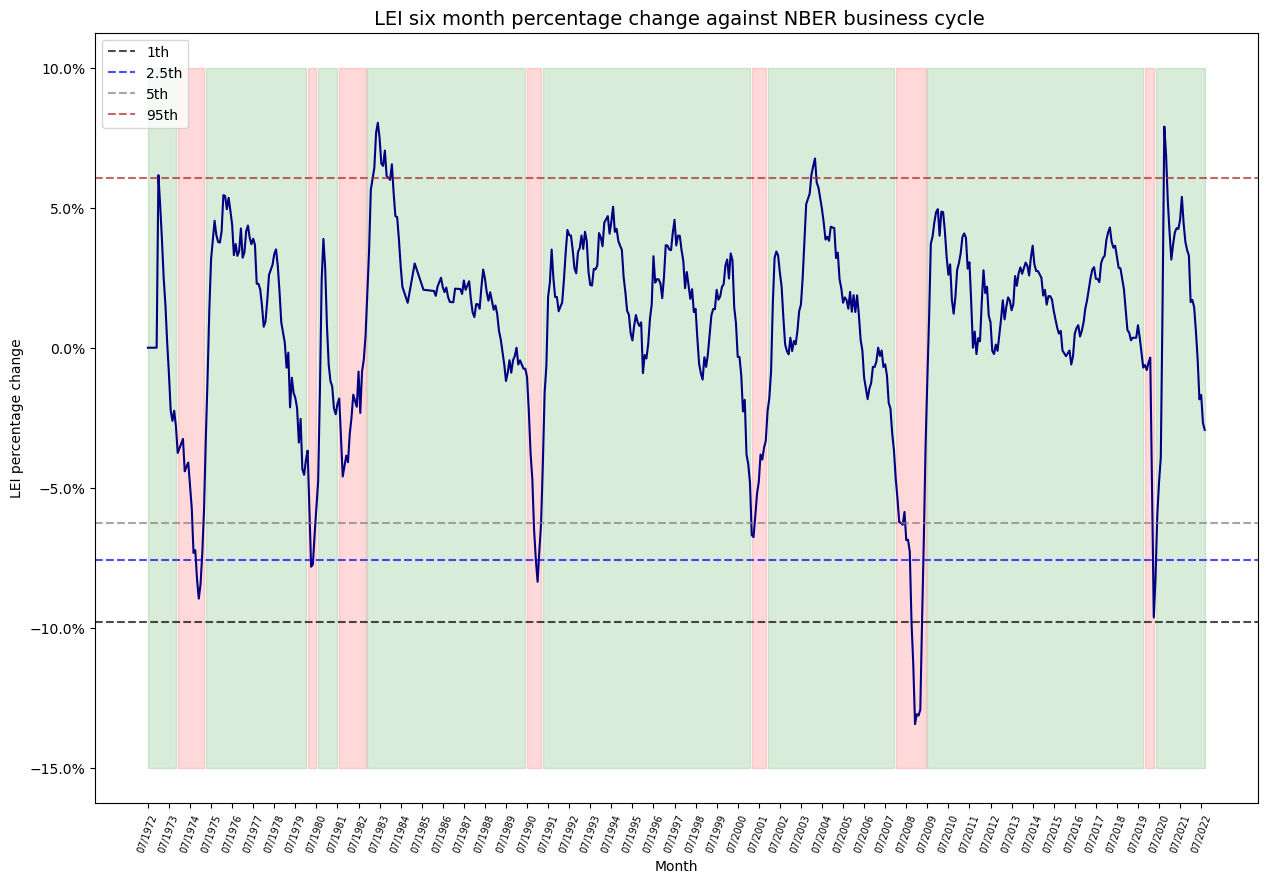

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
x = df2['month']
y = df2['delta_6m_LEI']*100
ax.plot(x, y, color='navy')
sub = df2.month[::12]
ax.set_xticks(sub)
ax.set_xticklabels(sub, fontdict={'fontsize':7}, rotation=70)
plt.xlabel('Month')
plt.ylabel('LEI percentage change')
plt.title(' LEI six month percentage change against NBER business cycle', size=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

threshold_1=-0.098*100
threshold_2=-0.0757*100
threshold_3=-0.0626*100
threshold_4= 0.0607*100
ax.axhline(threshold_1, color='black' , alpha=0.7, linestyle="--", label='1th')
ax.axhline(threshold_2, color='blue' , alpha=0.7, linestyle="--", label='2.5th')
ax.axhline(threshold_3, color='grey' , alpha=0.7, linestyle="--", label='5th' )
ax.axhline(threshold_4, color='brown' , alpha=0.7, linestyle="--", label='95th')
plt.legend()

ax.fill_between(x, -15, 10, where=df['NBER'] =="expansion",
               color='green', alpha=0.15 )
ax.fill_between(x, -15, 10, where=df['NBER'] =="contraction",
               color='red', alpha=0.15 )
plt.savefig("Six_month_LEI_delta.png")
plt.show();

The six month LEI delta matches pretty well with recessions. The highest negative changes are all in the 5th percentile during recessions. Hence, a negative delta greater than 6.26% is sure to be happening during a recession. 

**As we can see, in 2022, we are nearly halfway there. If the speed accelerates, we are bound to meet a recession in the coming months. Expected GDP for the third quarter 2022 according to Atlanta's Fed GDPNow model is 2.9%.**

## Determining an algorithm for the four stages

I reviewed the dataset in Excel and propose the following algorithm for identifying the four stages of the cycle: 

1. When coming out of a contraction period (as marked by NBER), delta_1m and delta_3m turn positive simultaneously. This should mark beginning of the recovery or "light green" stage. 

2. During the recovery stage, at some point delta_6m decelerates, i.e. the change in delta_6m turns negative. This signals the transition from recovery to expansion. I call this the "dark green" stage. At least two deltas are positive during any given month. 

3. To reach a slowdown or "orange" stage, two of the three deltas are negative for two months in a row. The slowdown stage can signal a transition to the contraction stage or could be a blip during an expansion stage. If this is the case, when the three deltas are positive in a given month, it returns to the expansion stage.  

4. To arrive at the contraction (or "red") stage, the three deltas must be negative and delta_6m must show a decrease of more than 3% (that is -3%). 

The following code creates a color column, which will be added to a new dataframe. This new data set can be used for further visual analysis with color coded backgrounds of the economic cycle. 

In [23]:
rows=df2.shape[0] #number of rows
columns=df2.shape[1]  #number of columns

In [24]:
color="dark green"  # the initial value for july 72 is green, according to the rules described above. 
orange_counter=0    # counts the number of months where `sum_signs` is less than 2. 
                    #Two straight months marks the beginning of an orange phase
delta_6m_derivative=0 # the difference between delta_6m at "t" and delta_6m at "t-1"
sum_signs=0          # will add the positive observations among the three deltas for a given month. 
                     ## Minimum is zero, maximum is 3. 

## Initializing lists to store the values of estimations to later export to a new dataframe. 
##Delta lists start with zero, since no estimations have been performed yet.

list_derivative=[0]  # a list the contains the calculated values for delta_6m_derivative. It starts out at zero, since no calculations have been performed yet.    
list_color=["dark green"] #each month will have a color assigned in a new column, that is then added to the dataframe
list_month=[df2["month"][0]] 
list_LEI=[df2["LEI"][0]] 
list_CEI=[df2["CEI"][0]] 
list_NBER=[df2["NBER"][0]] 
list_delta_1m_LEI=[df2['delta_1m_LEI'][0]]
list_delta_3m_LEI=[df2['delta_3m_LEI'][0]]
list_delta_6m_LEI=[df2['delta_6m_LEI'][0]]
list_sign_delta_1m_LEI=[df2['sign_delta_1m_LEI'][0]]
list_sign_delta_3m_LEI=[df2['sign_delta_1m_LEI'][0]]
list_sign_delta_6m_LEI=[df2['sign_delta_1m_LEI'][0]]


In [25]:
for i in range(1,rows,1):
  m1=df2["sign_delta_1m_LEI"][i]
  m3=df2["sign_delta_3m_LEI"][i]
  m6=df2["sign_delta_6m_LEI"][i]
  sum_signs=m1+m3+m6
  delta_6m_derivative=df2["delta_6m_LEI"][i]-df2["delta_6m_LEI"][i-1]
  
#-------------Dark Green --------------
  if color =="dark green":
    
    #Orange
    if sum_signs==1 or sum_signs==0:
      orange_counter=orange_counter+1
      if orange_counter==2:  ## when orange counter hits 2, reset the counter to zero and asign the color orange
        orange_counter=0
        color="orange"

    #Dark green
    else:
      orange_counter=0       ## once a dark green is confirmed, the orange counter resets to zero  
      color ="dark green"
 
# An expansion phase cannot go back to a recovery phase, it transitions to a slowdown phase, 
# which can either recover or go into a contraction phase.   

#-------------Orange--------------
  elif color =="orange":
    #Red
    if sum_signs==0 and df2["delta_6m_LEI"][i]<-0.03:
      color="red"
    #Dark green
    elif sum_signs==3:
      color ="dark green"  
    #Orange
    else:
      color="orange"

#-------------Red --------------
  elif color =="red":
    #Light green
    if m1==1 and m3==1:
      color ="light green"

#-------------Light green --------------
  elif color =="light green":
    # Orange
    if sum_signs==1 or sum_signs==0:
      orange_counter=orange_counter+1
      if orange_counter==2:
        orange_counter=0
        color="orange"
    # Dark green 
    elif sum_signs==3 and delta_6m_derivative <0:
      orange_counter=0
      color ="dark green"
    #Light green 
    else:
      orange_counter=0
      color ="light green"
  
## extracting the correspoding values for to export to csv   
  list_month.append(df2["month"][i]) 
  list_LEI.append(df2["LEI"][i])
  list_CEI.append(df2["CEI"][i]) 
  list_NBER.append(df2["NBER"][i]) 
  list_delta_1m_LEI.append(df2['delta_1m_LEI'][i])
  list_delta_3m_LEI.append(df2['delta_3m_LEI'][i])
  list_delta_6m_LEI.append(df2['delta_6m_LEI'][i])
  list_sign_delta_1m_LEI.append(df2['sign_delta_1m_LEI'][i])
  list_sign_delta_3m_LEI.append(df2['sign_delta_3m_LEI'][i])
  list_sign_delta_6m_LEI.append(df2['sign_delta_6m_LEI'][i])
  
## Appending the calculated values to lists to export to csv
  list_color.append(color)
  list_derivative.append(delta_6m_derivative)
 

In [26]:
## Transforming lists into a dataframe
output_data={
    "month":list_month,
    "LEI": list_LEI,
    "CEI":list_CEI,
    "NBER": list_NBER,
    "delta_1m_LEI":list_delta_1m_LEI,
    "delta_3m_LEI":list_delta_3m_LEI,
    "delta_6m_LEI":list_delta_6m_LEI,
    "sign_delta_1m_LEI": list_sign_delta_1m_LEI,
    "sign_delta_3m_LEI": list_sign_delta_3m_LEI,
    "sign_delta_6m_LEI": list_sign_delta_6m_LEI,
    "color":list_color,
    "sec_deriv_delta_6m":list_derivative,
    }
 
df3 = pd.DataFrame(data=output_data)

In [27]:
df3.head()

,month,LEI,CEI,NBER,delta_1m_LEI,delta_3m_LEI,delta_6m_LEI,sign_delta_1m_LEI,sign_delta_3m_LEI,sign_delta_6m_LEI,color,sec_deriv_delta_6m
0,07/1972,50.3,39.5,expansion,0.000000,0.000000,0.0,0,0,0,dark green,0.0
1,08/1972,51.0,39.9,expansion,0.013917,0.000000,0.0,1,0,0,dark green,0.0
2,09/1972,51.6,40.2,expansion,0.011765,0.000000,0.0,1,0,0,orange,0.0
3,10/1972,52.0,40.7,expansion,0.007752,0.033797,0.0,1,1,0,orange,0.0
4,11/1972,52.5,41.0,expansion,0.009615,0.029412,0.0,1,1,0,orange,0.0


In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               603 non-null    object 
 1   LEI                 603 non-null    float64
 2   CEI                 603 non-null    float64
 3   NBER                603 non-null    object 
 4   delta_1m_LEI        603 non-null    float64
 5   delta_3m_LEI        603 non-null    float64
 6   delta_6m_LEI        603 non-null    float64
 7   sign_delta_1m_LEI   603 non-null    int64  
 8   sign_delta_3m_LEI   603 non-null    int64  
 9   sign_delta_6m_LEI   603 non-null    int64  
 10  color               603 non-null    object 
 11  sec_deriv_delta_6m  603 non-null    float64
dtypes: float64(6), int64(3), object(3)
memory usage: 56.7+ KB


*The new dataset is complete and ready for the next stage of the analysis*

## Contrasting the algorithm against the CEI 

If the algorithm is accurate, we should see that the color codings coincide with the line plot of CEI. Since the coincident index is a good predictor of GDP, it should tell if the economy is accelerating or decelarating. 

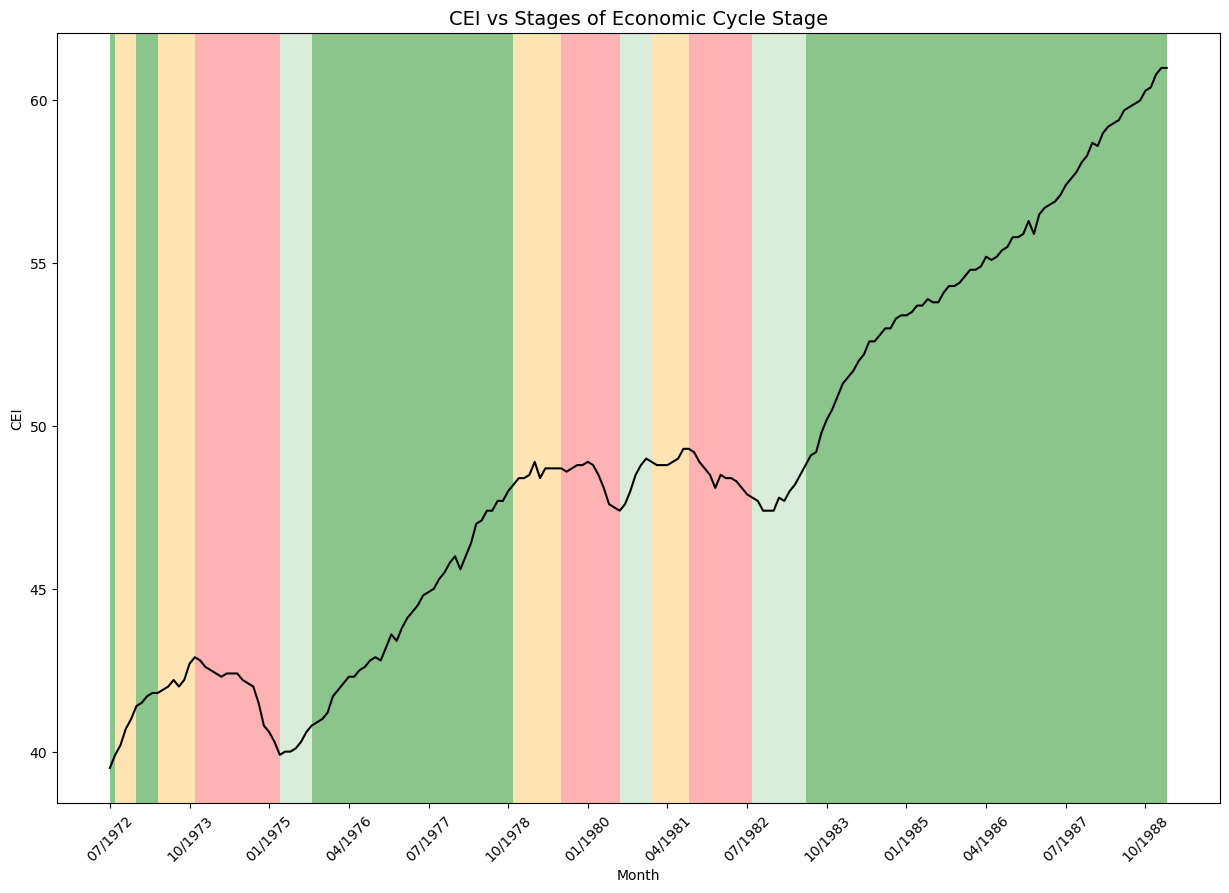

In [29]:
### Plotting the first 200 observations
fig, ax = plt.subplots(figsize=(15,10))
x = df3['month'][0:200] 
y = df3['CEI'][0:200]
ax.plot(x, y, color='black')
w=ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(w, rotation=45)
plt.xlabel('Month')
plt.ylabel('CEI')
plt.title('CEI vs Stages of Economic Cycle Stage', size=14)

for i in range(1,200,1):
 
  if df3['color'][i]  =="dark green":
    ax.axvspan(i-1, i, color='green', alpha=0.45, linewidth=0 )
  elif df3['color'][i]  =="light green":
    ax.axvspan(i-1, i, color='green', alpha=0.15, linewidth=0 )
  elif df3['color'][i]  =="red":
    ax.axvspan(i-1, i,   color='red', alpha=0.30, linewidth=0 )
  elif df3['color'][i]  =="orange":
    ax.axvspan(i-1, i, color='orange', alpha=0.30, linewidth=0 )
  else:
    pass

#plt.savefig("CEI-200.png")
plt.show();

The CEI seems in sync with the color coding. It decreases in red periods, stalls in orange periods, rebounds rapidly in light green periods and grows continously in dark green periods. 

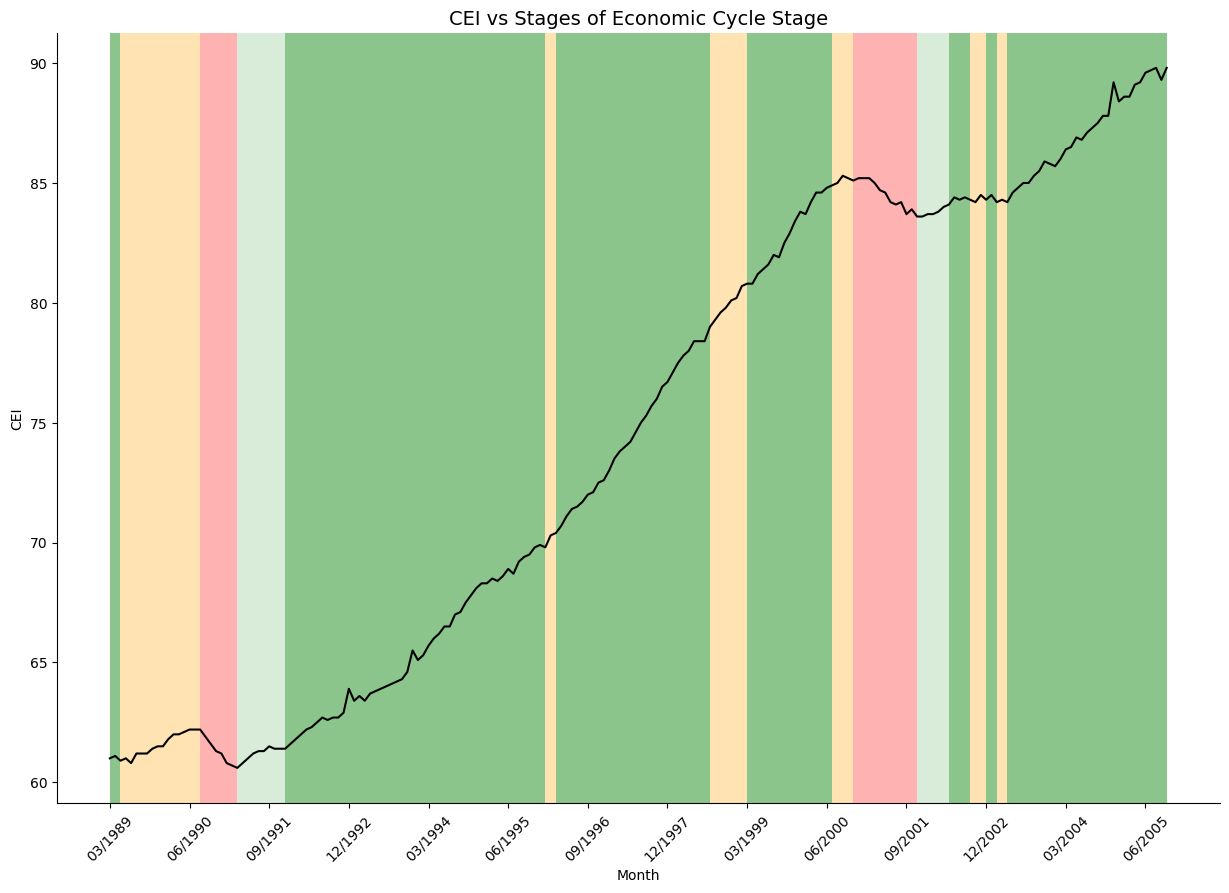

In [30]:
### Plotting the next 200 observations
fig, ax = plt.subplots(figsize=(15,10))
x = df3['month'][200:400] 
y = df3['CEI'][200:400]
ax.plot(x, y, color='black')
w=ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(w, rotation=45)
plt.xlabel('Month')
plt.ylabel('CEI')
plt.title('CEI vs Stages of Economic Cycle Stage', size=14)
sns.despine()
 
for i in range(1,200): 
  if df3['color'][i+200]  =="dark green":
    ax.axvspan(i-1, i, color='green', alpha=0.45, linewidth=0 )
  elif df3['color'][i+200]  =="light green":
    ax.axvspan(i-1, i, color='green', alpha=0.15, linewidth=0 )
  elif df3['color'][i+200]  =="red":
    ax.axvspan(i-1, i,   color='red', alpha=0.30, linewidth=0 )
  elif df3['color'][i+200]  =="orange":
    ax.axvspan(i-1, i, color='orange', alpha=0.30, linewidth=0 )
  else:
    pass
#plt.savefig("2nd-200_CEI.png")
plt.show();

In this case, a couple of orange periods in the nineties did not lead to a recession. 

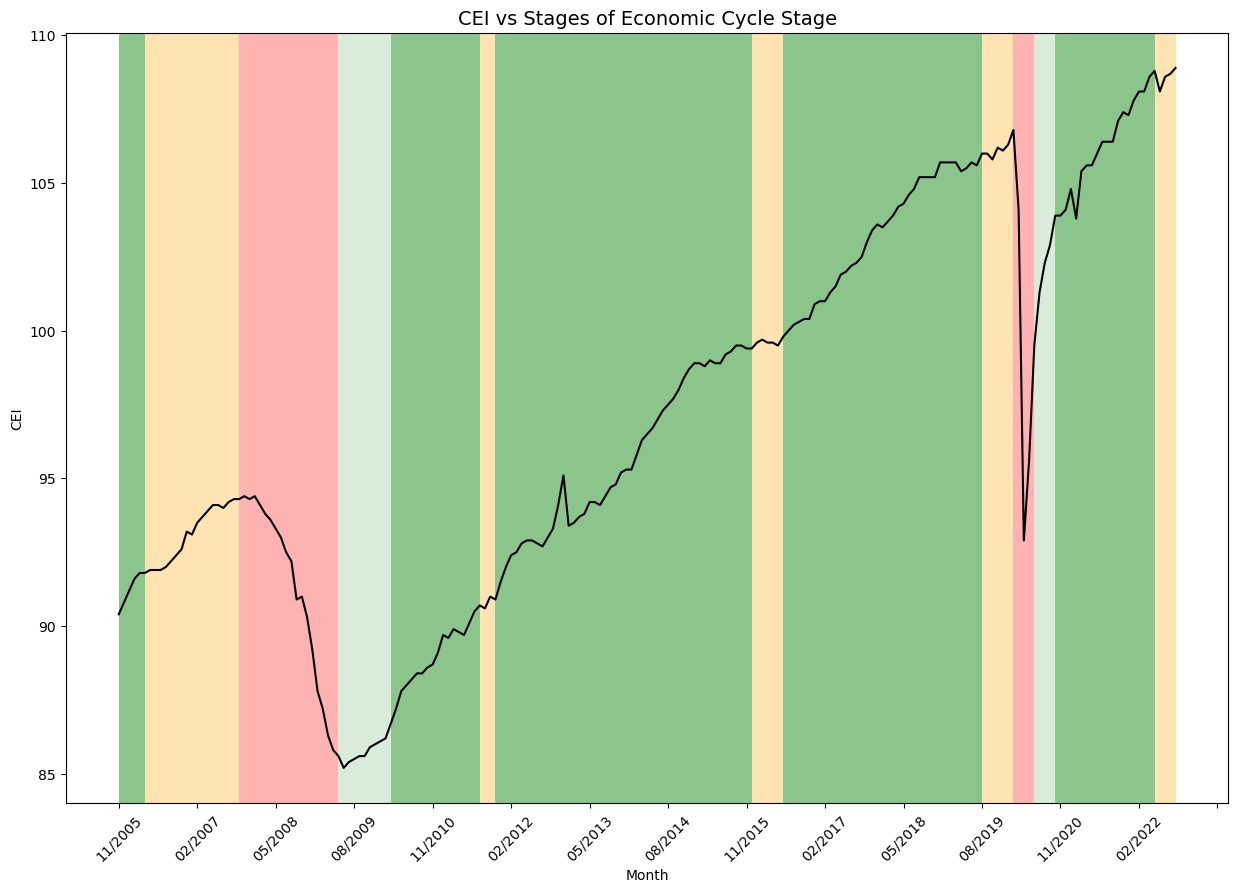

In [31]:
### Plotting the next 200 observations
fig, ax = plt.subplots(figsize=(15,10))
x = df3['month'][400:604] 
y = df3['CEI'][400:604]
ax.plot(x, y, color='black')
w=ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(w, rotation=45)
plt.xlabel('Month')
plt.ylabel('CEI')
plt.title('CEI vs Stages of Economic Cycle Stage', size=14)
 
for i in range(1,203): 
  if df3['color'][i+400]  =="dark green":
    ax.axvspan(i-1, i, color='green', alpha=0.45, linewidth=0 )
  elif df3['color'][i+400]  =="light green":
    ax.axvspan(i-1, i, color='green', alpha=0.15, linewidth=0 )
  elif df3['color'][i+400]  =="red":
    ax.axvspan(i-1, i,   color='red', alpha=0.30, linewidth=0 )
  elif df3['color'][i+400]  =="orange":
    ax.axvspan(i-1, i, color='orange', alpha=0.30, linewidth=0 )
  else:
    pass

plt.show();

Conversely, a couple of orange periods in the 2010s did not lead to a recession. It seems we are currently in a slowdown phase because of the algorithm and the CEI is behaving as it did in previous orange phases. 